## CARE Noise2Void Denoising with Synthetic Microsim Dataset

This notebook demonstrates Noise2Void (N2V) denoising on synthetic microscopy data generated using Microsim. The dataset consists of simulated microtubule-like structures with realistic noise properties, allowing us to evaluate denoising performance against a perfect ground truth.

### Part 1: Generating Synthetic Data with Microsim

We'll use the Janelia COSEM dataset to create realistic cellular structures. The COSEM dataset contains segmented organelles from electron microscopy data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tifffile import imread, imwrite
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics.utils import autocorrelation
from microssim import micro_structural_similarity

# Import microsim for data generation
from microsim import schema as ms
from microsim.util import ortho_plot

# Create output directory
output_dir = Path("./microsim_cosem_data")
output_dir.mkdir(exist_ok=True)


In [11]:
# Create a simpler simulation with Identity modality
sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(
        shape=(64, 512, 512),
        scale=(0.064, 0.064, 0.064),
    ),
    output_space=ms.DownscaledSpace(downscale=4),
    sample=[
        ms.FluorophoreDistribution(
            distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
            concentration=0.1,
            fluorophore="EGFP"
        ),
    ],
    channels=[
        ms.OpticalConfig.from_fpbase(microscope_id="wKqWbg", config_name="Widefield Green")
    ],
    modality=ms.Identity(),
    detector=ms.CameraCCD(gain=2),
)
# Generate images with greater exposure difference
gt_image = sim.digital_image(exposure_ms=100)
noisy_image = sim.digital_image(exposure_ms=5)

### Visualizing the generated data

GT slice shape: (128, 128)


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

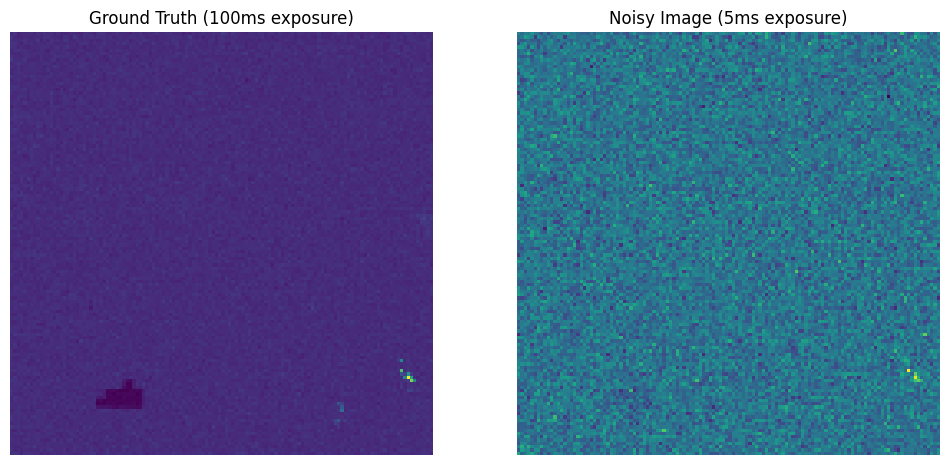

In [18]:
gt_slice = gt_image[0, z_middle].values 
noisy_slice = noisy_image[0, z_middle].values

print(f"GT slice shape: {gt_slice.shape}")

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(gt_slice, cmap='viridis')
ax[0].set_title("Ground Truth (100ms exposure)")
ax[0].axis('off')
ax[1].imshow(noisy_slice, cmap='viridis')
ax[1].set_title("Noisy Image (5ms exposure)")
ax[1].axis('off')

## Part 2: Noise2Void Denoising with CAREamics
Now that we have our synthetic dataset with ground truth, we'll train a Noise2Void model to denoise our images.


### Configure and train the Noise2Void model

In [20]:
config = create_n2v_configuration(
    experiment_name="microsim_n2v_2d",
    data_type="array",
    axes="YX", 
    patch_size=(64, 64),
    batch_size=16, 
    num_epochs=100,
)

# The slices are already extracted above
# Save 2D slices (no need to modify these gt_slice and noisy_slice)
imwrite(output_dir / "ground_truth_2d.tif", gt_slice.astype(np.float32))
imwrite(output_dir / "noisy_image_2d.tif", noisy_slice.astype(np.float32))

# Initialize and train the model
careamist = CAREamist(source=config)
careamist.train(
    train_source=noisy_slice,
    val_percentage=0.1,
)

No working directory provided. Using current working directory: /home/diya.srivastava/Desktop/repos/careamics-examples/applications/n2v/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Computed dataset mean: [102.25177002], std: [2.95880787]
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/diya.srivastava/Desktop/repos/careamics-examples/applications/n2v/2D/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
-----

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


### Make predictions using the trained model

In [22]:
predictions = careamist.predict(
    source=noisy_slice,
    data_type="array",
    axes="YX",
    tile_size=(128, 128),
    tile_overlap=(32, 32),
    batch_size=1,
)
denoised_images = np.squeeze(np.array(predictions))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

### Evaluate denoising performance and visualize the results

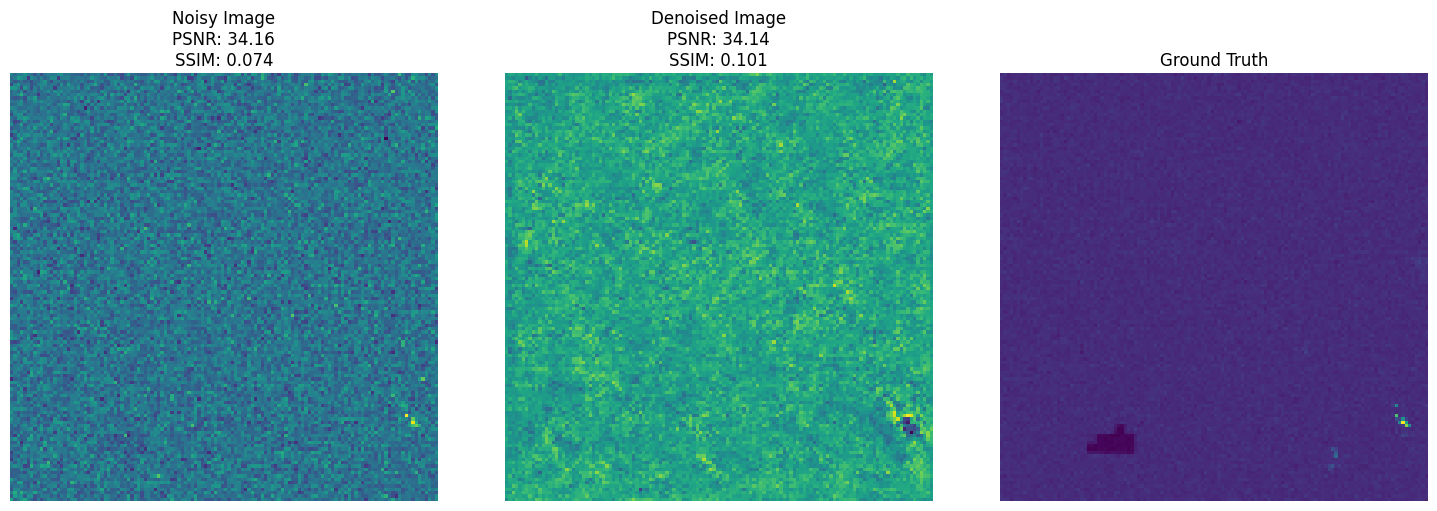

PSNR (Noisy): 34.16, SSIM: 0.074
PSNR (Denoised): 34.14, SSIM: 0.101


In [25]:
# Compute PSNR and SSIM for both noisy and denoised images
psnr_noisy = scale_invariant_psnr(gt_slice, noisy_slice)
psnr_denoised = scale_invariant_psnr(gt_slice, denoised_images)
ssim_noisy = micro_structural_similarity(noisy_slice, gt_slice)
ssim_denoised = micro_structural_similarity(denoised_images, gt_slice)

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(noisy_slice, cmap='viridis')
plt.title(f'Noisy Image\nPSNR: {psnr_noisy:.2f}\nSSIM: {ssim_noisy:.3f}')
plt.axis('off')

plt.subplot(132)
plt.imshow(denoised_images, cmap='viridis')
plt.title(f'Denoised Image\nPSNR: {psnr_denoised:.2f}\nSSIM: {ssim_denoised:.3f}')
plt.axis('off')

plt.subplot(133)
plt.imshow(gt_slice, cmap='viridis')
plt.title('Ground Truth')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"PSNR (Noisy): {psnr_noisy:.2f}, SSIM: {ssim_noisy:.3f}")
print(f"PSNR (Denoised): {psnr_denoised:.2f}, SSIM: {ssim_denoised:.3f}")

### Plot training metrics

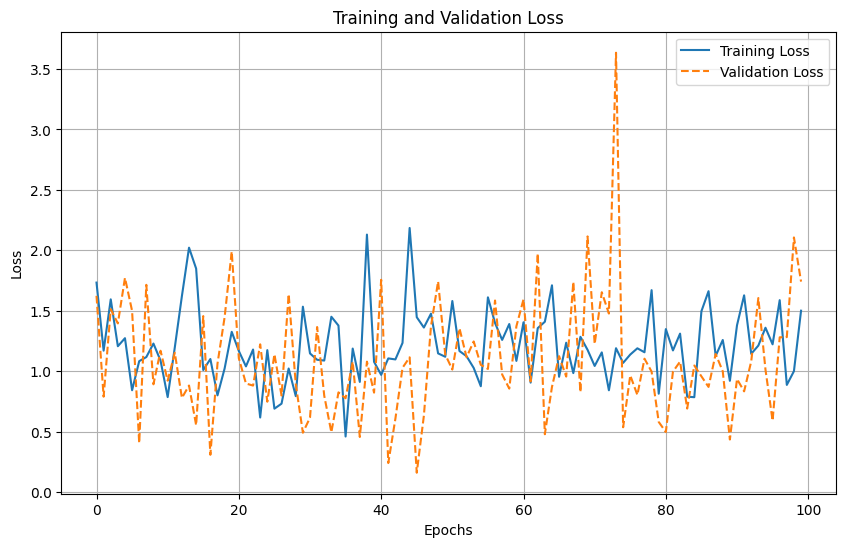

In [26]:
# Retrieve the training and validation losses
losses = careamist.get_losses()

# Extract train and validation losses
train_losses = losses.get('train_loss', [])
val_losses = losses.get('val_loss', [])
train_epochs = list(range(len(train_losses)))
val_epochs = list(range(len(val_losses)))

# Plot the losses
plt.figure(figsize=(10, 6))
if train_losses:
    plt.plot(train_epochs, train_losses, label='Training Loss')
if val_losses:
    plt.plot(val_epochs, val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

### Create a visualization for a comparison of before/after

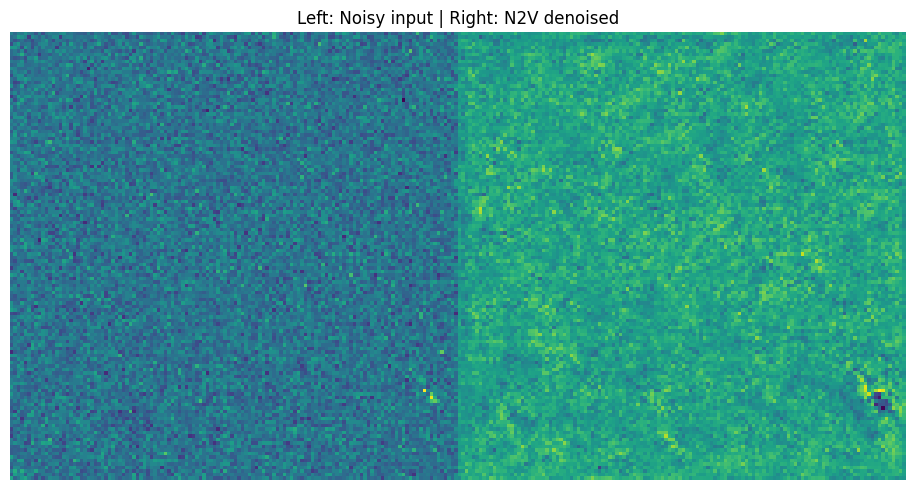

In [28]:
# Create a side-by-side comparison image
size = 128
# Create image canvas
comparison = np.zeros((size, size*2))

# Just use the 2D slices directly
norm_noisy = (noisy_slice - noisy_slice.min()) / (noisy_slice.max() - noisy_slice.min())
norm_denoised = (denoised_images - denoised_images.min()) / (denoised_images.max() - denoised_images.min())

# Fill in halves (select region if needed, or use whole image)
comparison[:, :size] = norm_noisy
comparison[:, size:] = norm_denoised

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(comparison, cmap="viridis")
plt.title("Left: Noisy input | Right: N2V denoised")
plt.axis('off')
plt.tight_layout()
plt.savefig("Microsim_N2V_comparison.jpg", dpi=300, bbox_inches='tight')
plt.show()

### Now we can export the model to BMZ format

In [31]:
# Define description for the model
general_description = """
This model is trained using the Noise2Void (N2V) algorithm to denoise synthetic microscopy images 
generated with Microsim. The images simulate tubular structures resembling microtubules labeled 
with EGFP and imaged using a widefield fluorescence microscope.

N2V enables training without clean data by masking pixels and predicting their values from 
surrounding context.
"""
# Export the model
careamist.export_to_bmz(
    path_to_archive="microsim_n2v_model.zip",
    friendly_model_name="Microsim_N2V",
    input_array=noisy_slice.astype(np.float32),  # Use 2D slice
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
    general_description=general_description,
    data_description="Synthetic widefield fluorescence microscopy data of EGFP-labeled mitochondrial membranes simulated with Microsim"
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

computing SHA256 of inputs.npy (result: debb96de9c436b1500be4c87920d8cda40f1273430c59003cc788e2a8f8f2a91): 100%|██████████| 65664/65664 [00:00<00:00, 84121801.42it/s] 
computing SHA256 of outputs.npy (result: 01b50aa51e5cea68bb7a2bcb4bff28d9ace5e393fa88283534a585b3510fa146): 100%|██████████| 65664/65664 [00:00<00:00, 11790016.18it/s] 
computing SHA256 of environment.yml (result: fcb28a47de772ad4152cc36bed5c7166c0e67bcf50462610439fe1816b84d075): 100%|██████████| 157/157 [00:00<00:00, 235685.66it/s]
computing SHA256 of weights.pth (result: efdd886afe32c62a62a34769236b23514492db7ce40e99b5b7c23e5a7efc8a6a): 100%|██████████| 2066750/2066750 [00:00<00:00, 801384653.05it/s] 
computing SHA256 of careamics.yaml (result: b5629d3a8fd5d382e4fa2014ebaae5cbd0df3513bec1b20dc56a46ca411a7f98): 100%|██████████| 1314/1314 [00:00<00:00, 2109998.26it/s]
2025-03-24 13:22:42.368 | Level 30 | bioimageio.spec.model.v0_5:_validate_documentation:2106 - documentation: No '# Validation' (sub)section found in /home